In [1]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
tables = Gaia.load_tables()

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [5]:
job = Gaia.launch_job("SELECT TOP 200000 source_id, age_flame, age_flame_upper, age_flame_lower, ra, dec, mh_msc, evolstage_flame, \
                      lum_flame, radius_flame, \
                      distance_msc, radius_gspphot, gravredshift_flame, bc_flame \
                      FROM gaiadr3.astrophysical_parameters AS asp JOIN gaiadr3.gaia_source as source USING (source_id) WHERE asp.age_flame > 0")
r = job.get_results()

In [6]:
print(r[:10])

     source_id      age_flame ... gravredshift_flame   bc_flame  
                       Gyr    ...       km / s           mag     
------------------- --------- ... ------------------ ------------
4295968474406905728 7.0794244 ...          0.1605195 -0.061366986
5823962291768533120  8.371422 ...         0.33043656   0.08714286
2251512776728277376  9.558605 ...          0.6724094  -0.18352905
2251512811088015104 7.0820885 ...          0.5982347  -0.13737452
2251512841151485440 1.4780635 ...          0.3166536  0.009334879
2251512845447746432  8.540051 ...         0.65674853 -0.012082349
4295870342996284544 1.9412465 ...         0.22732635  -0.36349684
5901272768238766464 3.6956193 ...         0.56822795 0.0029659013
5901272768238770816 5.7322016 ...          0.4177453  0.066695355
5901272768238772480  0.455834 ...         0.16531976   0.11211238


In [7]:
arr = np.array([np.array([elem[i] for i in range(len(elem))]) for elem in r])

C:\Users\Jorda\AppData\Local\Temp\ipykernel_1788\2274823958.py:1: UserWarning: Warning: converting a masked element to nan.
  arr = np.array([np.array([elem[i] for i in range(len(elem))]) for elem in r])


In [8]:
print(arr.shape)

(200000, 14)


In [9]:
train_dataset = arr[:160000]
test_dataset = arr[160000:]

In [10]:
train_labels = train_dataset[:,1:2]
train_data = train_dataset[:,4:]


In [11]:
train_data = np.nan_to_num(train_data, nan = -99)

In [12]:
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(train_data)

In [13]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=keras.optimizers.Adam(0.001))
  return model

In [14]:
model = build_and_compile_model(normalizer)

In [15]:
#model.compile(
#    optimizer=keras.optimizers.Adam(learning_rate=0.01),
#    loss='mean_absolute_error')

In [16]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [17]:
history = model.fit(
    train_data,
    train_labels,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    validation_split=0.2,
    batch_size=128,
    verbose=0, epochs=100)


Epoch 35: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 63: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 78: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')

  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
    

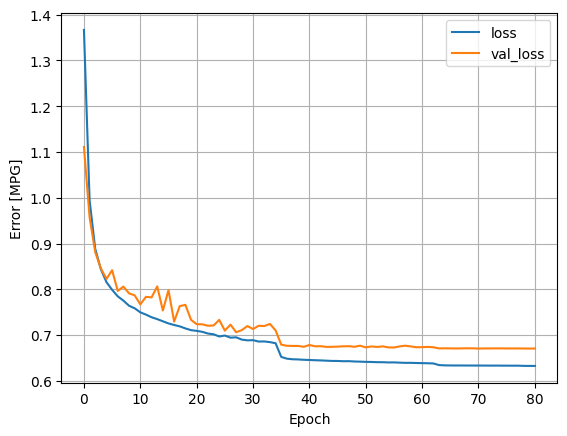

In [19]:
plot_loss(history)

In [20]:
print(history.history['loss'])

[1.3665423393249512, 0.9947659373283386, 0.8881634473800659, 0.8438299894332886, 0.815482497215271, 0.7987876534461975, 0.7845500707626343, 0.7752043604850769, 0.7640709280967712, 0.7584663033485413, 0.7496554851531982, 0.7446659803390503, 0.7389295697212219, 0.7348331809043884, 0.7300621271133423, 0.7253909111022949, 0.7220327854156494, 0.719003438949585, 0.7144896388053894, 0.7106890678405762, 0.7091848850250244, 0.7070419788360596, 0.7033543586730957, 0.7017369866371155, 0.6969097256660461, 0.6989192962646484, 0.6943315267562866, 0.6951155662536621, 0.6901076436042786, 0.6884238719940186, 0.6888572573661804, 0.6858173608779907, 0.6860706210136414, 0.6845610737800598, 0.6821877956390381, 0.6523025631904602, 0.648439884185791, 0.6471558809280396, 0.6467428803443909, 0.6460012793540955, 0.6455543637275696, 0.645035982131958, 0.6446499228477478, 0.6440432667732239, 0.6435188055038452, 0.6434205770492554, 0.6428687572479248, 0.642969012260437, 0.6422649621963501, 0.6419071555137634, 0.64

In [21]:
test_labels = test_dataset[:,1:2]
test_data = test_dataset[:,4:]
test_data = np.nan_to_num(test_data, nan = -99)
print(test_dataset.shape)

#train_labels = train_dataset[:,1:2]
#train_data = train_dataset[:,4:]

(40000, 14)


In [22]:
for i in range(10):
    print(model.predict(test_data[i]), test_labels[i])

1/1 [==============================] - 0s 68ms/step
[[4.9702544]] [3.38305783]
1/1 [==============================] - 0s 26ms/step
[[11.054045]] [3.25645256]
1/1 [==============================] - 0s 14ms/step
[[0.74822485]] [0.74782014]
1/1 [==============================] - 0s 13ms/step
[[8.636542]] [12.54908371]
1/1 [==============================] - 0s 14ms/step
[[3.753983]] [5.45850086]
1/1 [==============================] - 0s 18ms/step
[[5.411028]] [0.71356457]
1/1 [==============================] - 0s 20ms/step
[[8.355502]] [6.12442255]
1/1 [==============================] - 0s 12ms/step
[[8.950465]] [8.53900909]
1/1 [==============================] - 0s 13ms/step
[[3.878181]] [2.66123676]
1/1 [==============================] - 0s 15ms/step
[[9.722463]] [8.05149078]


In [23]:
# left test_data, right actual
#test_data[i] test_labels[i]) 

#observed vs calculated

#save model.predict into array

#a = sum(((test_labels - model.predict(test_data)) ** 2) / (((r["age_flame_upper"] - r["age_flame_lower"]) ** 2) / 4)) #upper - lower

b = sum((((test_labels - model.predict(test_data)) ** 2) / ((test_dataset[:,2:3] - test_dataset[:,3:4]) ** 2) / 4))
b
#train_dataset = arr[:160000]
#test_dataset = arr[160000:]

1250/1250 [==============================] - 1s 630us/step


array([4240.67827013])

In [24]:
import pandas
table = []
real = []
difference123 = []
sourceids = []

styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "150%"),
                              ("color", 'black')])]

for i in range(20):
    table.append(model.predict(test_data[i])[0][0])
    real.append(test_labels[i][0])
    difference123.append(abs(model.predict(test_data[i])[0][0] - test_labels[i][0]))
    sourceids.append(r[i][0])

    
#
datatestthing = {'Source ID': sourceids, 'Predicted': table, 'Actual': real, "Absolute Difference": difference123}
df = pandas.DataFrame(data=datatestthing)
df = df.style.set_caption("Predicted Age vs Actual Age [Gyr]").set_table_styles(styles)
df


1/1 [==============================] - 0s 13ms/step


,Source ID,Predicted,Actual,Absolute Difference
0,4295968474406905856,4.970254,3.383058,1.587197
1,5823962291768532992,11.054045,3.256453,7.797592
2,2251512776728277504,0.748225,0.747820,0.000405
3,2251512811088015104,8.636542,12.549084,3.912541
4,2251512841151485440,3.753983,5.458501,1.704518
5,2251512845447746560,5.411028,0.713565,4.697463
6,4295870342996284416,8.355502,6.124423,2.231080
7,5901272768238766080,8.950465,8.539009,0.411456
8,5901272768238771200,3.878181,2.661237,1.216944
9,5901272768238772224,9.722463,8.051491,1.670972


In [33]:
job1233 = Gaia.launch_job("SELECT TOP 200000 age_flame, age_flame_upper, age_flame_lower, ra, dec, mh_msc, evolstage_flame, \
                      lum_flame, radius_flame, \
                      distance_msc, radius_gspphot, gravredshift_flame, bc_flame \
                      FROM gaiadr3.astrophysical_parameters AS asp JOIN gaiadr3.gaia_source as source USING (source_id) WHERE asp.age_flame > 0")
newjob123 = job1233.get_results()

df = newjob123


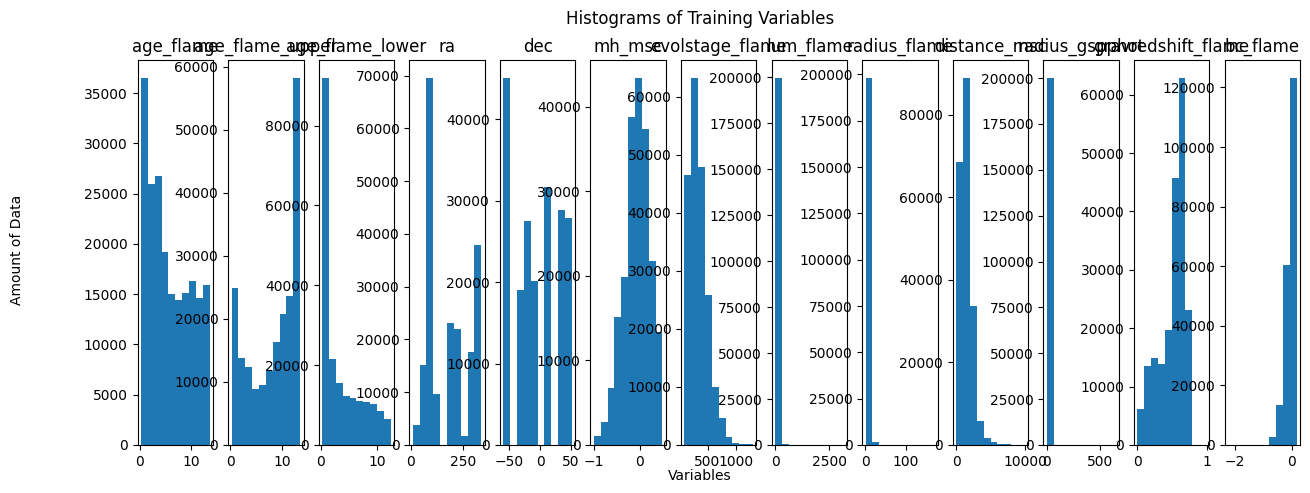

In [34]:

fig, axs = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(15, 5))


for i, col in enumerate(df.columns):
    axs[i].hist(df[col])
    axs[i].set_title(col)


fig.suptitle('Histograms of Training Variables')
fig.text(0.5, 0.04, 'Variables', ha='center')
fig.text(0.04, 0.5, 'Amount of Data', va='center', rotation='vertical')
plt.plot(figsize=(100,15))

plt.show()



